# ENCI 619.26 - Data Processing

The purpose of this coding assignment is:
- Perform data processing techniques (manipulation, cleaning, imputing missing data, etc.) to the term project dataset
- Perform exploratory data analysis (EDA) to uncover preliminary insights of the dataset

# 1 Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime as dt
import warnings
# Set maximum columns and rows display and supress all warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")
# Set plot for automatically display
%matplotlib inline

# 2 Load Primary and Supplementary Dataset

For this section we will be loading various dataset that we will be using for processing before conducting Machine Learning modeling. The datasets are:
- **Pedestrian Crash Data:** data obtained from *Public Safety Data Portal* of the *Toronto Police Service*. (**Link:** [https://data.torontopolice.on.ca/datasets/TorontoPS::pedestrians/about](https://data.torontopolice.on.ca/datasets/TorontoPS::pedestrians/about) 
- **Temperature Data:** data obtained from *Climate Data Extraction* tool from the Government of Canada site selecting City of Toronto as the search parameter. (**Link:** [https://climate-change.canada.ca/climate-data/#/hourly-climate-data](https://climate-change.canada.ca/climate-data/#/hourly-climate-data))
- **Pedestrian Flow Data:** data obtained from *City of Toronto Open Data Catalog*. The data imported here are aggregated *pedestrian average daily traffic (ADT)* per intersection. (**Link:** [https://open.toronto.ca/dataset/traffic-volumes-at-intersections-for-all-modes/](https://open.toronto.ca/dataset/traffic-volumes-at-intersections-for-all-modes/))
- **Dissemination Area and Census Data:** data obtained from the *Statistics Canada* website for the *City of Toronto* (Link: [https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=9810001501&geocode=S051235201205](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=9810001501&geocode=S051235201205))

We will load the **Pedestrian Crash Data** first and check the first 5 observations

In [2]:
DF = gpd.read_file(r"E:\Term Project 619.26\1_DATA FOR JOINING\pedestrian_crash_1.shp")

In [3]:
DF.head()

,INDEX_,ACCNUM,YEAR,DATE,TIME,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,WARDNUM,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,HOOD_158,NEIGHBOURH,HOOD_140,NEIGHBOU_1,DIVISION,ObjectId,Class_name,adt_ped,DAUID,geometry
0,3366651,884090,2006,2006-01-02,705,BATHURST ST,DUNDAS ST W,60 NORTH OF,Major Arterial,Toronto and East York,11,43.652892,-79.406253,Mid-Block,None,No Control,Other,"Dark, artificial",Wet,Non-Fatal Injury,Pedestrian Collisions,Driver,30 to 34,None,None,South,"Automobile, Station Wagon",Changing Lanes,Improper Lane Change,Inattentive,None,None,None,None,None,None,Yes,None,Yes,None,None,None,None,None,None,None,None,None,None,78,Kensington-Chinatown,78,Kensington-Chinatown (78),D14,1,MixedUse,219.0,35201436,POINT (-8839463.650 5411882.612)
1,3366652,884090,2006,2006-01-02,705,BATHURST ST,DUNDAS ST W,60 NORTH OF,Major Arterial,Toronto and East York,11,43.652892,-79.406253,Mid-Block,None,No Control,Other,"Dark, artificial",Wet,Non-Fatal Injury,Pedestrian Collisions,Pedestrian,45 to 49,Major,None,West,None,None,None,None,Pedestrian hit at mid-block,Crossing without right of way,Inattentive,None,None,None,Yes,None,Yes,None,None,None,None,None,None,None,None,None,None,78,Kensington-Chinatown,78,Kensington-Chinatown (78),D14,2,MixedUse,219.0,35201436,POINT (-8839463.650 5411882.612)
2,3370333,885782,2006,2006-01-04,1940,DUFFERIN ST,SYLVAN AVE,None,Major Arterial,Toronto and East York,9,43.655145,-79.433590,Mid-Block,At Intersection,Traffic Signal,Rain,Dark,Wet,Non-Fatal Injury,Pedestrian Collisions,Driver,25 to 29,None,None,South,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,None,None,None,None,None,None,Yes,None,Yes,None,None,None,None,None,None,None,None,None,None,83,Dufferin Grove,83,Dufferin Grove (83),D11,3,Neighbourhoods,63.0,35200944,POINT (-8842506.791 5412229.253)
3,3370334,885782,2006,2006-01-04,1940,DUFFERIN ST,SYLVAN AVE,None,Major Arterial,Toronto and East York,9,43.655145,-79.433590,Mid-Block,At Intersection,Traffic Signal,Rain,Dark,Wet,Non-Fatal Injury,Pedestrian Collisions,Pedestrian,75 to 79,Major,None,East,Other,None,None,None,Vehicle is going straight thru inter.while ped...,Crossing without right of way,Normal,None,None,None,Yes,None,Yes,None,None,None,None,None,None,None,None,None,None,83,Dufferin Grove,83,Dufferin Grove (83),D11,4,Neighbourhoods,63.0,35200944,POINT (-8842506.791 5412229.253)
4,3363337,882079,2006,2006-01-06,2210,DON MILLS RD,LEITH HILL RD,None,Major Arterial,North York,17,43.777056,-79.347858,Intersection,At Intersection,Traffic Signal,Clear,"Dark, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,50 to 54,None,None,South,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,None,None,None,None,None,None,Yes,None,Yes,None,None,None,None,None,None,None,None,None,None,47,Don Valley Village,47,Don Valley Village (47),D33,5,Neighbourhoods,50.0,35200280,POINT (-8832963.148 5431005.658)


The **Pedestrian Flow Data** has been appended in the shapefile data and therefore will not be loaded or be a part of this operation. However we will be loading the rest of supplementary data for joining later on.

In [4]:
# Loading temperature data
TEMP = pd.read_csv(r"E:\Term Project 619.26\Weather_Temperature\weather_data_final.csv")
# Loading dissemination area and census data
DA = pd.read_csv(r"E:\Term Project 619.26\DA_2021.csv")
# Create a mapping for speed limits based on the City's road classification
speed_limit_map = {
    'Major Arterial' : 50,
    'Minor Arterial' : 50,
    'Collector' : 40,
    'Local' : 40,
    'Expressway' : 110,
    'Other' : 40
}

# 3 Datetime Processing

We will now enter the process of converting date and time data to **datetime** data type. Code will be as follows:

In [5]:
DF['DATETIME'] = pd.to_datetime(DF['DATE'] + ' ' + DF['TIME'].str.zfill(4), format='%Y-%m-%d %H%M')
# Drop the unnecessary columns
DF.drop(['DATE', 'TIME'], axis=1, inplace=True)
# Finally check the datatype of the 'DATETIME' column to confirm
print(DF['DATETIME'].dtype)

datetime64[ns]


Now that we have a proper datetime column, we can extract other datetime elements for future analysis and processing operations

In [6]:
DF['YEAR'] = DF['DATETIME'].dt.year
DF['MONTH'] = DF['DATETIME'].dt.month
DF['DAY'] = DF['DATETIME'].dt.day
DF['HOUR'] = DF['DATETIME'].dt.hour
DF['DAYOFWEEK'] = DF['DATETIME'].dt.dayofweek
# Check if properly executed
DF.head(1)

,INDEX_,ACCNUM,YEAR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,WARDNUM,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,HOOD_158,NEIGHBOURH,HOOD_140,NEIGHBOU_1,DIVISION,ObjectId,Class_name,adt_ped,DAUID,geometry,DATETIME,MONTH,DAY,HOUR,DAYOFWEEK
0,3366651,884090,2006,BATHURST ST,DUNDAS ST W,60 NORTH OF,Major Arterial,Toronto and East York,11,43.652892,-79.406253,Mid-Block,None,No Control,Other,"Dark, artificial",Wet,Non-Fatal Injury,Pedestrian Collisions,Driver,30 to 34,None,None,South,"Automobile, Station Wagon",Changing Lanes,Improper Lane Change,Inattentive,None,None,None,None,None,None,Yes,None,Yes,None,None,None,None,None,None,None,None,None,None,78,Kensington-Chinatown,78,Kensington-Chinatown (78),D14,1,MixedUse,219.0,35201436,POINT (-8839463.650 5411882.612),2006-01-02 07:05:00,1,2,7,0


The `DAYOFWEEK` column needs to be transformed to either `weekday` or `weekend`

In [7]:
# Create a function that will convert the integer DAYOFWEEK to 'weekday' or 'weekend'
def dayofweek_convert(num):
    """
    Provide the column name where the integer day of week is contained. 
    This function will return the word equivalent
    i.e., 0 to 4 are considered as weekdays (Mon to Fri) and 5 to 6 are considered as weekends (Sat, Sun)
    """
    if num < 5:
        return 'weekday'
    else:
        return 'weekend'
# Apply to the current dataframe
DF['DAYOFWEEK'] = DF['DAYOFWEEK'].apply(dayofweek_convert)
# Check dataframe operation if applied correctly
DF.head(1)

,INDEX_,ACCNUM,YEAR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,WARDNUM,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,HOOD_158,NEIGHBOURH,HOOD_140,NEIGHBOU_1,DIVISION,ObjectId,Class_name,adt_ped,DAUID,geometry,DATETIME,MONTH,DAY,HOUR,DAYOFWEEK
0,3366651,884090,2006,BATHURST ST,DUNDAS ST W,60 NORTH OF,Major Arterial,Toronto and East York,11,43.652892,-79.406253,Mid-Block,None,No Control,Other,"Dark, artificial",Wet,Non-Fatal Injury,Pedestrian Collisions,Driver,30 to 34,None,None,South,"Automobile, Station Wagon",Changing Lanes,Improper Lane Change,Inattentive,None,None,None,None,None,None,Yes,None,Yes,None,None,None,None,None,None,None,None,None,None,78,Kensington-Chinatown,78,Kensington-Chinatown (78),D14,1,MixedUse,219.0,35201436,POINT (-8839463.650 5411882.612),2006-01-02 07:05:00,1,2,7,weekday


# 4 Joining Supplementary Dataset and Subsetting

Recall the supplemental data we loaded earlier in the analysis. We will now join those data to the main `DF` for future usage. We will first attach the temperature data followed by the dissemination area and census data. 

We will also subset the data further to focus on records that only involve pedestrians.

In [8]:
# Left join the temperature data to the main dataset
DF1 = pd.merge(DF, 
               TEMP[['YEAR', 'MONTH', 'DAY', 'HOUR', 'TEMP', 'RELATIVE_HUMIDITY', 'DEW_POINT_TEMP']],
              how="left",
              on=['YEAR', 'MONTH', 'DAY', 'HOUR'])
# Check if there are any missals
DF1[['TEMP', 'RELATIVE_HUMIDITY', 'DEW_POINT_TEMP']].isna().sum()

TEMP                 0
RELATIVE_HUMIDITY    0
DEW_POINT_TEMP       0
dtype: int64

In [9]:
# Convert the "DAUID" column in DF1 to integer type before doing the join
DF1['DAUID'] = DF1['DAUID'].astype('int64')
# Left join the dissemination and census data to DF1
DF2 = pd.merge(DF1, DA,
              how="left",
              on="DAUID")
# Check if there are any missals
DF2[['POP_2021','PRIV_DWELL', 'LAND_AREA', 'POP_DENS', 'POP_DENS_AREA']].isna().sum()

POP_2021         0
PRIV_DWELL       0
LAND_AREA        0
POP_DENS         0
POP_DENS_AREA    0
dtype: int64

The dataset is described as Pedestrians that are involved in crash, however the dataset is not properly filtered since the `INVTYPE` column still accounts for vehicles and we need to only select *Pedestrian* involvement. This would be bring the amount of observations from **7354** to almost half, **3113**

In [10]:
DF3 = DF2[(DF2['INVTYPE']=='Pedestrian') | (DF2['INVTYPE']=='Pedestrian - Not Hit')]
# Check the dimension of the new dataset
print(DF3.shape)

(3113, 70)


# 5 Feature Selection and Transformations

Not every attribute in this dataframe will be used for analysis and ML modeling therefore we will only select certain attributes based on existing literature but first let us check how much missing values each attributes have

In [11]:
DF3.reset_index(drop=True, inplace=True)

In [12]:
DF3.head(1)

,INDEX_,ACCNUM,YEAR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,WARDNUM,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,HOOD_158,NEIGHBOURH,HOOD_140,NEIGHBOU_1,DIVISION,ObjectId,Class_name,adt_ped,DAUID,geometry,DATETIME,MONTH,DAY,HOUR,DAYOFWEEK,TEMP,RELATIVE_HUMIDITY,DEW_POINT_TEMP,POP_2021,PRIV_DWELL,LAND_AREA,POP_DENS,POP_DENS_AREA
0,3366652,884090,2006,BATHURST ST,DUNDAS ST W,60 NORTH OF,Major Arterial,Toronto and East York,11,43.652892,-79.406253,Mid-Block,None,No Control,Other,"Dark, artificial",Wet,Non-Fatal Injury,Pedestrian Collisions,Pedestrian,45 to 49,Major,None,West,None,None,None,None,Pedestrian hit at mid-block,Crossing without right of way,Inattentive,None,None,None,Yes,None,Yes,None,None,None,None,None,None,None,None,None,None,78,Kensington-Chinatown,78,Kensington-Chinatown (78),D14,2,MixedUse,219.0,35201436,POINT (-8839463.650 5411882.612),2006-01-02 07:05:00,1,2,7,weekday,1.5,0.99,1.3,504,263,225,0.08,"6,537.00"


We will be selecting the desired attributes to conduct the exploratory data analysis and machine learnin modeling in the future

In [13]:
DF4 = DF3[['INDEX_', 'DATETIME', 'YEAR', 'MONTH', 'DAY', 'HOUR',
          'DAYOFWEEK', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'TEMP',
          'RELATIVE_HUMIDITY', 'DEW_POINT_TEMP', 'LOCCOORD',
          'TRAFFCTL', 'ROAD_CLASS', 'adt_ped', 'Class_name', 'HOOD_158',
          'DAUID', 'POP_2021', 'PRIV_DWELL', 'LAND_AREA', 'POP_DENS',
          'POP_DENS_AREA', 'INVAGE', 'PEDCOND', 'MANOEUVER', 'PEDACT',
          'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE','TRUCK', 'TRSN_CITY_', 'EMERG_VEH',
          'SPEEDING', 'AG_DRIV', 'ALCOHOL', 'DISABILITY', 'REDLIGHT', 'INJURY',
          'LATITUDE', 'LONGITUDE', 'geometry']]

In [14]:
DF4.head(1)

,INDEX_,DATETIME,YEAR,MONTH,DAY,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,RELATIVE_HUMIDITY,DEW_POINT_TEMP,LOCCOORD,TRAFFCTL,ROAD_CLASS,adt_ped,Class_name,HOOD_158,DAUID,POP_2021,PRIV_DWELL,LAND_AREA,POP_DENS,POP_DENS_AREA,INVAGE,PEDCOND,MANOEUVER,PEDACT,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_,EMERG_VEH,SPEEDING,AG_DRIV,ALCOHOL,DISABILITY,REDLIGHT,INJURY,LATITUDE,LONGITUDE,geometry
0,3366652,2006-01-02 07:05:00,2006,1,2,7,weekday,Other,"Dark, artificial",Wet,1.5,0.99,1.3,Mid-Block,No Control,Major Arterial,219.0,MixedUse,78,35201436,504,263,225,0.08,"6,537.00",45 to 49,Inattentive,None,Crossing without right of way,None,Yes,None,None,None,None,None,None,None,None,None,Major,43.652892,-79.406253,POINT (-8839463.650 5411882.612)


## Identifying and Imputing Missing Data
Some preliminary data imputation where conducted in *ArcGIS Pro* and this section will impute missing data for most of the categorical values and some numerical datatypes, if any. Let us first see which attributes have some missing data.

Let us visualize how much missing data for each attributes have.

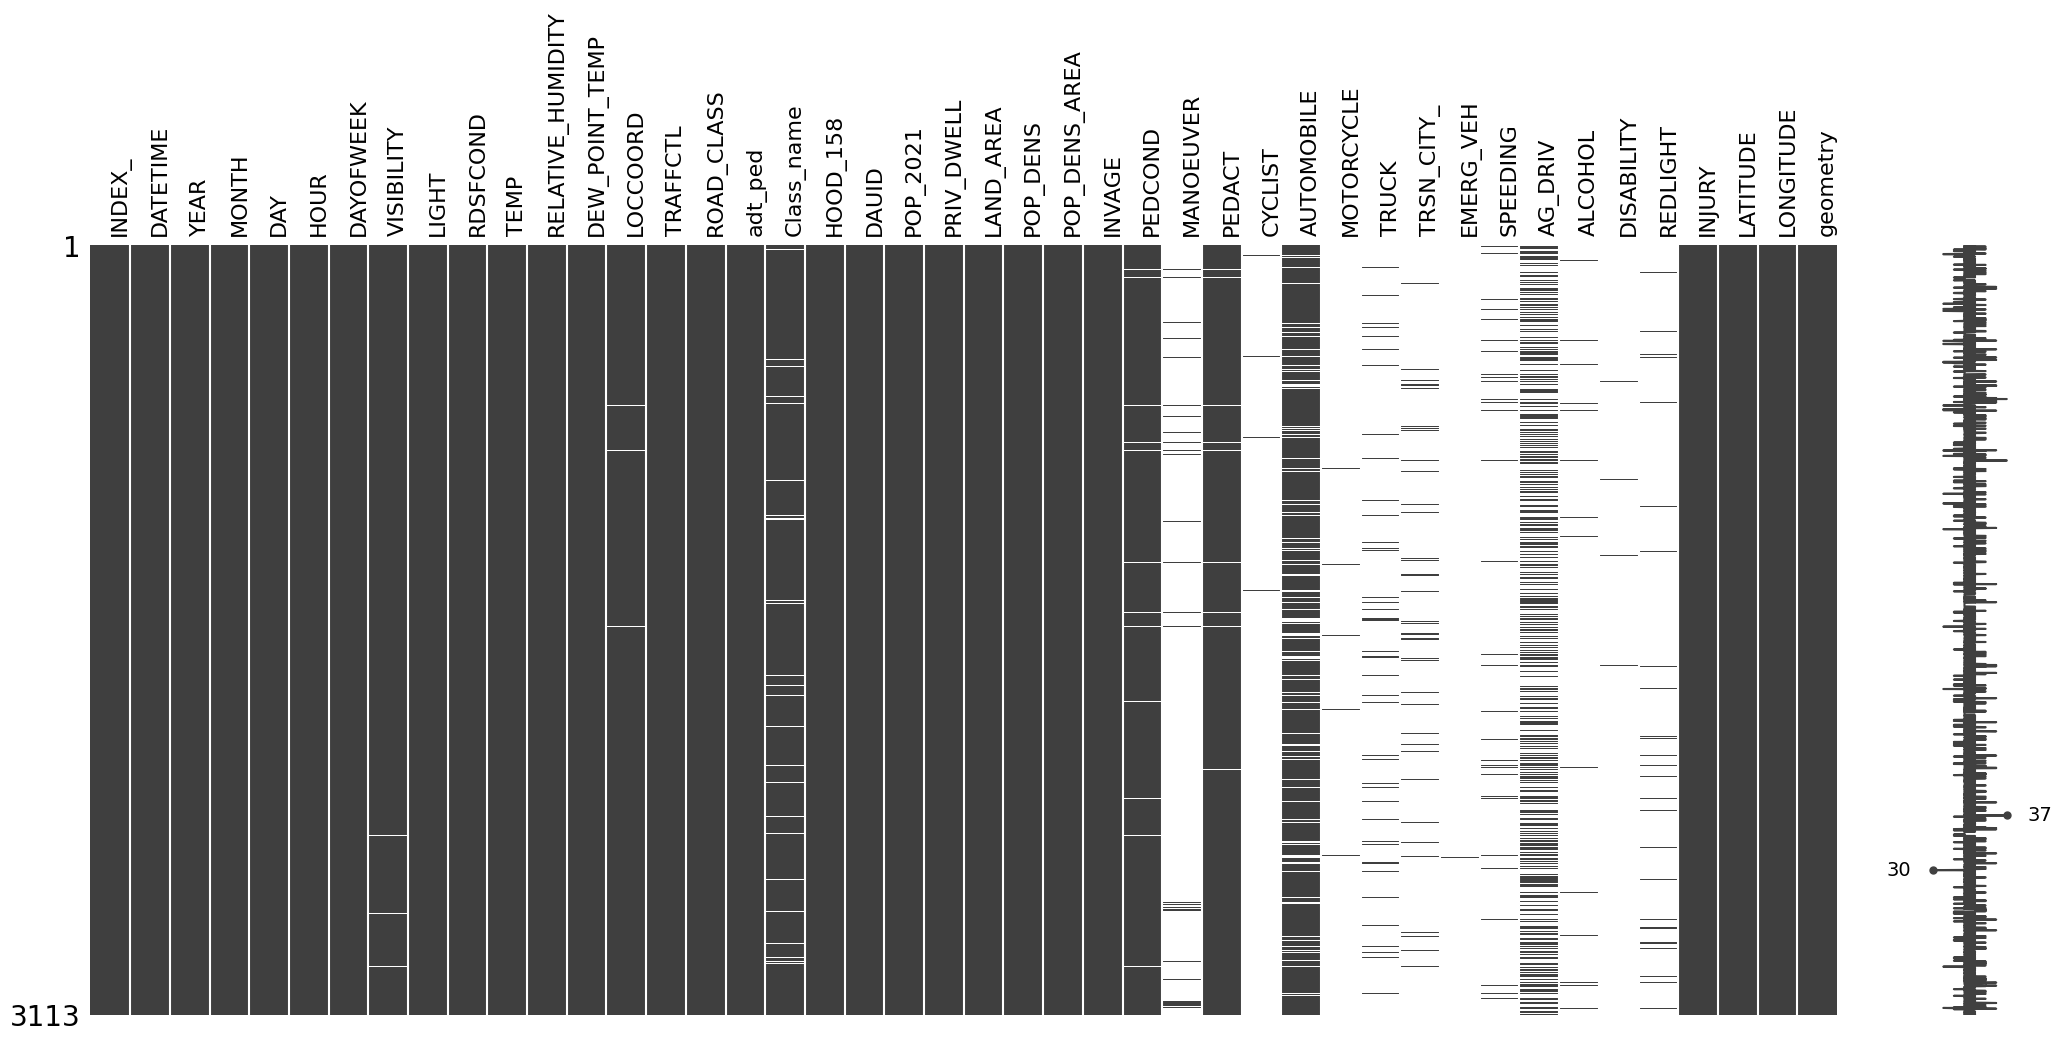

In [15]:
import missingno as msno
msno.matrix(DF4, label_rotation=90)
plt.savefig('missing_data.png', dpi=600)

We will check this again for our processed data

Now that we know the attributes with missing data, let us impute them using the instructions below:
- `VISIBILITY`, `Class_name`, `PEDCOND`, `MANOEUVER`, `PEDACT` - impute **'Unknown'**
- `LOCCOORD` - impute **'Intersection'**
- VEHINV and VIOL variables will be imputed with **'No'**

In [16]:
impute_value = 'Unknown'
columns = ['VISIBILITY', 'Class_name', 'PEDCOND', 'MANOEUVER', 'PEDACT']
for col in columns:
    DF4[col].fillna(impute_value, inplace=True)
# Let us check if the columns above still missing some data
DF4[columns].isna().sum()

VISIBILITY    0
Class_name    0
PEDCOND       0
MANOEUVER     0
PEDACT        0
dtype: int64

In [17]:
DF4['LOCCOORD'].fillna('Intersection', inplace=True)

In [18]:
columns2 = ['CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE','TRUCK', 'TRSN_CITY_', 'EMERG_VEH', 'SPEEDING', 
            'AG_DRIV', 'ALCOHOL', 'DISABILITY', 'REDLIGHT']
for col in columns2:
    DF4[col].fillna('No', inplace=True)
DF4[columns2].isna().sum()

CYCLIST       0
AUTOMOBILE    0
MOTORCYCLE    0
TRUCK         0
TRSN_CITY_    0
EMERG_VEH     0
SPEEDING      0
AG_DRIV       0
ALCOHOL       0
DISABILITY    0
REDLIGHT      0
dtype: int64

## Transformations

In this section, we will clean up the existing dataset by grouping similar responses and renaming some of the attributes. 

Let us first rename some of the columns.

In [19]:
dict_map = {
    'RELATIVE_HUMIDITY' : 'REL_HUMID',
    'DEW_POINT_TEMP' : 'DEW_POINT',
    'ROAD_CLASS' : 'ROADCLASS',
    'adt_ped' : 'PED_ADT',
    'Class_name' : 'LAND_USE',
    'POP_DENS_AREA' : 'PDENS_AREA'
}
DF4.rename(columns=dict_map, inplace=True)

In [20]:
DF4.head(1)

,INDEX_,DATETIME,YEAR,MONTH,DAY,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,DEW_POINT,LOCCOORD,TRAFFCTL,ROADCLASS,PED_ADT,LAND_USE,HOOD_158,DAUID,POP_2021,PRIV_DWELL,LAND_AREA,POP_DENS,PDENS_AREA,INVAGE,PEDCOND,MANOEUVER,PEDACT,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_,EMERG_VEH,SPEEDING,AG_DRIV,ALCOHOL,DISABILITY,REDLIGHT,INJURY,LATITUDE,LONGITUDE,geometry
0,3366652,2006-01-02 07:05:00,2006,1,2,7,weekday,Other,"Dark, artificial",Wet,1.5,0.99,1.3,Mid-Block,No Control,Major Arterial,219.0,MixedUse,78,35201436,504,263,225,0.08,"6,537.00",45 to 49,Inattentive,Unknown,Crossing without right of way,No,Yes,No,No,No,No,No,No,No,No,No,Major,43.652892,-79.406253,POINT (-8839463.650 5411882.612)


In [21]:
# Another renaming of columnns for the VEHINV and VIOL attributes
rename_map = {
    'CYCLIST' : 'cyclist',
    'AUTOMOBILE' : 'automobile',
    'MOTORCYCLE' : 'motorcycle',
    'TRUCK' : 'truck',
    'TRSN_CITY_' : 'transit vehicle',
    'EMERG_VEH' : 'emergency vehicle',
    'SPEEDING' : 'speeding',
    'AG_DRIV' : 'aggressive driving',
    'ALCOHOL' : 'alcohol-related',
    'DISABILITY' : 'disability-related',
    'REDLIGHT' : 'running a red light'
}
DF4.rename(columns=rename_map, inplace=True)

In [22]:
DF4.head()

,INDEX_,DATETIME,YEAR,MONTH,DAY,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,DEW_POINT,LOCCOORD,TRAFFCTL,ROADCLASS,PED_ADT,LAND_USE,HOOD_158,DAUID,POP_2021,PRIV_DWELL,LAND_AREA,POP_DENS,PDENS_AREA,INVAGE,PEDCOND,MANOEUVER,PEDACT,cyclist,automobile,motorcycle,truck,transit vehicle,emergency vehicle,speeding,aggressive driving,alcohol-related,disability-related,running a red light,INJURY,LATITUDE,LONGITUDE,geometry
0,3366652,2006-01-02 07:05:00,2006,1,2,7,weekday,Other,"Dark, artificial",Wet,1.5,0.99,1.3,Mid-Block,No Control,Major Arterial,219.0,MixedUse,78,35201436,504,263,225,0.08,"6,537.00",45 to 49,Inattentive,Unknown,Crossing without right of way,No,Yes,No,No,No,No,No,No,No,No,No,Major,43.652892,-79.406253,POINT (-8839463.650 5411882.612)
1,3370334,2006-01-04 19:40:00,2006,1,4,19,weekday,Rain,Dark,Wet,4.8,1.00,4.8,Mid-Block,Traffic Signal,Major Arterial,63.0,Neighbourhoods,83,35200944,452,205,183,0.15,"3,005.30",75 to 79,Normal,Unknown,Crossing without right of way,No,Yes,No,No,No,No,No,No,No,No,No,Major,43.655145,-79.433590,POINT (-8842506.791 5412229.253)
2,3363338,2006-01-06 22:10:00,2006,1,6,22,weekday,Clear,"Dark, artificial",Dry,-5.8,0.67,-10.9,Intersection,Traffic Signal,Major Arterial,50.0,Neighbourhoods,47,35200280,807,375,322,0.06,"12,995.20",25 to 29,Inattentive,Unknown,Crossing with right of way,No,Yes,No,No,No,No,No,No,No,No,No,Major,43.777056,-79.347858,POINT (-8832963.148 5431005.658)
3,3363869,2006-01-08 18:28:00,2006,1,8,18,weekend,Clear,Dark,Dry,2.4,0.76,-1.4,Intersection,Pedestrian Crossover,Major Arterial,8.0,Neighbourhoods,5,35201822,907,315,305,0.16,"5,585.00",10 to 14,Normal,Unknown,"Crossing, Pedestrian Crossover",No,Yes,No,No,No,No,No,Yes,No,No,No,Fatal,43.721445,-79.558090,POINT (-8856366.067 5422435.863)
4,3363416,2006-01-09 14:35:00,2006,1,9,14,weekday,Clear,Daylight,Dry,3.5,0.78,0.0,Intersection,Traffic Signal,Major Arterial,43.0,ApartmentNeighbourhoods,126,35204131,974,371,364,0.91,"1,068.20",75 to 79,Unknown,Unknown,Crossing without right of way,No,Yes,No,No,No,No,No,No,No,No,No,Fatal,43.769445,-79.282290,POINT (-8825664.152 5429832.313)


### Reverting the One-Hot Encode
The eleven (11) attributes before the `INJURY` column needs to be collated into two (2) attributes. For the first six (6), it will be labelled as the `VEHINV` variable and the rest will be called `VIOL`

In [24]:
binary_convert = {
    "Yes" : 1,
    "No" : 0
}
DF4.iloc[:,29:40] = DF4.iloc[:,29:40].replace(binary_convert) 

In [25]:
DF4.head(1)

,INDEX_,DATETIME,YEAR,MONTH,DAY,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,DEW_POINT,LOCCOORD,TRAFFCTL,ROADCLASS,PED_ADT,LAND_USE,HOOD_158,DAUID,POP_2021,PRIV_DWELL,LAND_AREA,POP_DENS,PDENS_AREA,INVAGE,PEDCOND,MANOEUVER,PEDACT,cyclist,automobile,motorcycle,truck,transit vehicle,emergency vehicle,speeding,aggressive driving,alcohol-related,disability-related,running a red light,INJURY,LATITUDE,LONGITUDE,geometry
0,3366652,2006-01-02 07:05:00,2006,1,2,7,weekday,Other,"Dark, artificial",Wet,1.5,0.99,1.3,Mid-Block,No Control,Major Arterial,219.0,MixedUse,78,35201436,504,263,225,0.08,"6,537.00",45 to 49,Inattentive,Unknown,Crossing without right of way,0,1,0,0,0,0,0,0,0,0,0,Major,43.652892,-79.406253,POINT (-8839463.650 5411882.612)


In [40]:
revert_col_vehinv = DF4.columns[29:35].tolist()
revert_col_viol = DF4.columns[35:40].tolist()

In [43]:
DF4[revert_col_vehinv] = DF4[revert_col_vehinv].astype('int64')

In [44]:
DF4[revert_col_viol] = DF4[revert_col_viol].astype('int64')

In [46]:
decoded_vehinv = DF4[revert_col_vehinv].idxmax(axis=1)
decoded_viol = DF4[revert_col_viol].idxmax(axis=1)

In [47]:
DF4['VEHINV'] = decoded_vehinv
DF4['VIOL'] = decoded_viol

In [48]:
DF4.head(1)

,INDEX_,DATETIME,YEAR,MONTH,DAY,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,DEW_POINT,LOCCOORD,TRAFFCTL,ROADCLASS,PED_ADT,LAND_USE,HOOD_158,DAUID,POP_2021,PRIV_DWELL,LAND_AREA,POP_DENS,PDENS_AREA,INVAGE,PEDCOND,MANOEUVER,PEDACT,cyclist,automobile,motorcycle,truck,transit vehicle,emergency vehicle,speeding,aggressive driving,alcohol-related,disability-related,running a red light,INJURY,LATITUDE,LONGITUDE,geometry,VEHINV,VIOL
0,3366652,2006-01-02 07:05:00,2006,1,2,7,weekday,Other,"Dark, artificial",Wet,1.5,0.99,1.3,Mid-Block,No Control,Major Arterial,219.0,MixedUse,78,35201436,504,263,225,0.08,"6,537.00",45 to 49,Inattentive,Unknown,Crossing without right of way,0,1,0,0,0,0,0,0,0,0,0,Major,43.652892,-79.406253,POINT (-8839463.650 5411882.612),automobile,speeding


In [49]:
drop_columns = DF4.columns[29:40].tolist()
DF4 = DF4.drop(columns=drop_columns, axis=1)
DF4.head(1)

,INDEX_,DATETIME,YEAR,MONTH,DAY,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,DEW_POINT,LOCCOORD,TRAFFCTL,ROADCLASS,PED_ADT,LAND_USE,HOOD_158,DAUID,POP_2021,PRIV_DWELL,LAND_AREA,POP_DENS,PDENS_AREA,INVAGE,PEDCOND,MANOEUVER,PEDACT,INJURY,LATITUDE,LONGITUDE,geometry,VEHINV,VIOL
0,3366652,2006-01-02 07:05:00,2006,1,2,7,weekday,Other,"Dark, artificial",Wet,1.5,0.99,1.3,Mid-Block,No Control,Major Arterial,219.0,MixedUse,78,35201436,504,263,225,0.08,"6,537.00",45 to 49,Inattentive,Unknown,Crossing without right of way,Major,43.652892,-79.406253,POINT (-8839463.650 5411882.612),automobile,speeding


In [51]:
# Move the VEHINV and VIOL column
column_to_move = 'VEHINV'
position = 29
column = DF4.pop(column_to_move)
DF4.insert(position, column_to_move, column)
DF4.head(1)

,INDEX_,DATETIME,YEAR,MONTH,DAY,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,DEW_POINT,LOCCOORD,TRAFFCTL,ROADCLASS,PED_ADT,LAND_USE,HOOD_158,DAUID,POP_2021,PRIV_DWELL,LAND_AREA,POP_DENS,PDENS_AREA,INVAGE,PEDCOND,MANOEUVER,PEDACT,VEHINV,INJURY,LATITUDE,LONGITUDE,geometry,VIOL
0,3366652,2006-01-02 07:05:00,2006,1,2,7,weekday,Other,"Dark, artificial",Wet,1.5,0.99,1.3,Mid-Block,No Control,Major Arterial,219.0,MixedUse,78,35201436,504,263,225,0.08,"6,537.00",45 to 49,Inattentive,Unknown,Crossing without right of way,automobile,Major,43.652892,-79.406253,POINT (-8839463.650 5411882.612),speeding


In [52]:
column_to_move = 'VIOL'
position = 30
column = DF4.pop(column_to_move)
DF4.insert(position, column_to_move, column)
DF4.head(1)

,INDEX_,DATETIME,YEAR,MONTH,DAY,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,DEW_POINT,LOCCOORD,TRAFFCTL,ROADCLASS,PED_ADT,LAND_USE,HOOD_158,DAUID,POP_2021,PRIV_DWELL,LAND_AREA,POP_DENS,PDENS_AREA,INVAGE,PEDCOND,MANOEUVER,PEDACT,VEHINV,VIOL,INJURY,LATITUDE,LONGITUDE,geometry
0,3366652,2006-01-02 07:05:00,2006,1,2,7,weekday,Other,"Dark, artificial",Wet,1.5,0.99,1.3,Mid-Block,No Control,Major Arterial,219.0,MixedUse,78,35201436,504,263,225,0.08,"6,537.00",45 to 49,Inattentive,Unknown,Crossing without right of way,automobile,speeding,Major,43.652892,-79.406253,POINT (-8839463.650 5411882.612)


### Grouping Categorical Variable values

Let's check for the unique values of each categorical variable

In [53]:
column_to_group = ['LIGHT', 'RDSFCOND', 'LOCCOORD', 'TRAFFCTL', 'LAND_USE', 'PEDCOND', 'PEDACT']
for col in column_to_group:
    print(f"{DF4[col].value_counts()}\n")

LIGHT
Daylight                1656
Dark                     643
Dark, artificial         641
Dusk                      49
Dusk, artificial          49
Dawn, artificial          29
Daylight, artificial      28
Dawn                      17
Other                      1
Name: count, dtype: int64

RDSFCOND
Dry                     2344
Wet                      689
Other                     28
Loose Snow                19
Slush                     15
Ice                        7
Packed Snow                6
Unknown                    4
Loose Sand or Gravel       1
Name: count, dtype: int64

LOCCOORD
Intersection            2163
Mid-Block                947
Mid-Block (Abnormal)       3
Name: count, dtype: int64

TRAFFCTL
No Control              1444
Traffic Signal          1378
Stop Sign                203
Pedestrian Crossover      63
Traffic Controller        11
Streetcar (Stop for)       6
Yield Sign                 4
Traffic Gate               2
School Guard               1
Police Control  

In [54]:
# LIGHT
# create a mapping dictionary to replace the column
light_new = {
    'Dark, artificial' : 'Dark',
    'Dusk, artificial' : 'Dusk',
    'Dawn, artificial' : 'Dawn',
    'Daylight, artificial' : 'Daylight'
}
# Use the replace method to replace the specified column
DF4['LIGHT'] = DF4['LIGHT'].replace(light_new)
# Check unique values now
DF4['LIGHT'].unique()

array(['Dark', 'Daylight', 'Dusk', 'Dawn', 'Other'], dtype=object)

In [55]:
# RDSFCOND
surface = {
    'Ice' : 'Ice/Slush',
    'Slush' : 'Ice/Slush',
    'Packed Snow' : 'Snow',
    'Loose Snow' : 'Snow'
}
DF4['RDSFCOND'] = DF4['RDSFCOND'].replace(surface)
DF4['RDSFCOND'].unique()

array(['Wet', 'Dry', 'Ice/Slush', 'Other', 'Snow', 'Loose Sand or Gravel',
       'Unknown'], dtype=object)

In [56]:
# LOCCOORD
location = {
    'Mid-Block' : 'Midblock',
    'Mid-Block (Abnormal)' : 'Midblock'
}
DF4['LOCCOORD'] = DF4['LOCCOORD'].replace(location)
DF4['LOCCOORD'].unique()

array(['Midblock', 'Intersection'], dtype=object)

In [57]:
# TRAFFCTL
control = {
    'Traffic Signal' : 'Traffic Signal including Transit',
    'Streetcar (Stop for)' : 'Traffic Signal including Transit',
    'Stop Sign' : 'Other Traffic Control',
    'Traffic Controller' : 'Other Traffic Control',
    'Yield Sign' : 'Other Traffic Control',
    'Traffic Gate' : 'Other Traffic Control',
    'School Guard' : 'Other Traffic Control',
    'Police Control' : 'Other Traffic Control'
}
DF4['TRAFFCTL'] = DF4['TRAFFCTL'].replace(control)
DF4['TRAFFCTL'].unique()

array(['No Control', 'Traffic Signal including Transit',
       'Pedestrian Crossover', 'Other Traffic Control'], dtype=object)

In [60]:
# LAND_USE
lu = {
    'Neighbourhoods' : 'Residential',
    'ApartmentNeighbourhoods' : 'Residential',
    'GeneralEmployment' : 'Commercial',
    'CoreEmploymentAreas' : 'Commercial',
    'OtherOpenSpace' : 'Other Open Space',
    'MixedUse' : 'Mixed Use'
}
DF4['LAND_USE'] = DF4['LAND_USE'].replace(lu)
DF4['LAND_USE'].unique()

array(['Mixed Use', 'Residential', 'Parks', 'Unknown', 'Commercial',
       'Natural areas', 'Regeneration', 'Other Open Space',
       'Institutional'], dtype=object)

In [63]:
# PEDCOND
pedcond = {
    'Had Been Drinking': 'Impaired - Alcohol (BAC = Normal)',
    'Ability Impaired, Alcohol' : 'Impaired - Alcohol (BAC = Normal)',
    'Ability Impaired, Alcohol Over .80' : 'Impaired - Alcohol (BAC > 0.08)',
    'Ability Impaired, Drugs' : 'Impaired - Drugs',
    'Inattentive' : 'Distracted',
    'Impaired, Alcohol (BAC = Normal)' : 'Impaired - Alcohol (BAC = Normal)'
}
DF4['PEDCOND'] = DF4['PEDCOND'].replace(pedcond)
DF4['PEDCOND'].value_counts()

PEDCOND
Normal                               1727
Distracted                            554
Unknown                               415
Impaired - Alcohol (BAC = Normal)     254
Other                                  71
Medical or Physical Disability         68
Impaired - Alcohol (BAC > 0.08)        12
Impaired - Drugs                       10
Fatigue                                 2
Name: count, dtype: int64

In [64]:
# PEDACT
pedact = {
    'Crossing with right of way' : 'Crossing with ROW',
    'Crossing, no Traffic Control' : 'Crossing with ROW and no control',
    'Crossing without right of way' : 'Crossing without ROW',
    'On Sidewalk or Shoulder' : 'Other',
    'Running onto Roadway' : 'Crossing without ROW',
    'Crossing, Pedestrian Crossover' : 'Crossing with ROW',
    'Person Getting on/off Vehicle ' : 'Other',
    'Coming From Behind Parked Vehicle' : 'Other',
    'Walking on Roadway with Traffic' : 'Crossing with ROW',
    'Walking on Roadway Against Traffic' : 'Crossing without ROW',
    'Playing or Working on Highway' : 'Other',
    'Crossing marked crosswalk without ROW' : 'Crossing without ROW',
    'Pushing/Working on Vehicle' : 'Other',
    'Person Getting on/off School Bus' : 'Other',
    'Person Getting on/off Vehicle' : 'Other'
}
DF4['PEDACT'] = DF4['PEDACT'].replace(pedact)
DF4['PEDACT'].value_counts()

PEDACT
Crossing with ROW                   1054
Crossing with ROW and no control     715
Crossing without ROW                 681
Other                                610
Unknown                               53
Name: count, dtype: int64

In [65]:
# ROADCLASS
roadclass = {
    'Laneway' : 'Other',
    'Expressway Ramp' : 'Other',
    'Pending' : 'Other'
}
DF4['ROADCLASS'] = DF4['ROADCLASS'].replace(roadclass)
DF4['ROADCLASS'].value_counts()

ROADCLASS
Major Arterial    2241
Minor Arterial     472
Collector          186
Local              181
Expressway          23
Other               10
Name: count, dtype: int64

In [69]:
list_age = DF4['INVAGE'].unique().tolist()

In [73]:
list_age

['0 to 4',
 '10 to 14',
 '15 to 19',
 '20 to 24',
 '25 to 29',
 '30 to 34',
 '35 to 39',
 '40 to 44',
 '45 to 49',
 '5 to 9',
 '50 to 54',
 '55 to 59',
 '60 to 64',
 '65 to 69',
 '70 to 74',
 '75 to 79',
 '80 to 84',
 '85 to 89',
 '90 to 94',
 'Over 95',
 'unknown']

In [76]:
# INVAGE
age_mapping = {
    '0 to 4' : 'Under 15',
    '5 to 9' : 'Under 15',
    '10 to 14' : 'Under 15',
    '15 to 19' : '15 to 29',
    '20 to 24' : '15 to 29',
    '25 to 29' : '15 to 29',
    '30 to 34' : '30 to 44',
    '35 to 39' : '30 to 44',
    '40 to 44' : '30 to 44',
    '45 to 49' : '45 to 64',
    '50 to 54' : '45 to 64',
    '55 to 59' : '45 to 64',
    '60 to 64' : '45 to 64',
    '65 to 69' : 'Over 65',
    '70 to 74' : 'Over 65',
    '75 to 79' : 'Over 65',
    '80 to 84' : 'Over 65',
    '85 to 89' : 'Over 65',
    '90 to 94' : 'Over 65',
    'Over 95' : 'Over 65',
    'unknown' : 'Unknown'
}
DF4['INVAGE'] = DF4['INVAGE'].replace(age_mapping)
DF4['INVAGE'].value_counts()

INVAGE
Over 65     854
45 to 64    808
15 to 29    663
30 to 44    558
Under 15    179
Unknown      51
Name: count, dtype: int64

## Miscellaneous Tasks

For the report, exclude the variables `DATETIME` and `DAUID` because they won't be part of the modeling. Also remove the `LATITUDE`, `LONGITUDE`, and `geometry` because they will also be not part of modeling. Remove `HOOD_158` attribute since there are a lot of unique values for this. 

The following tasks are still to be executed:
- Add in another attribute that is the **speed limit** as per the City's Vision Zero Safety Plan and MTO values
- Convert the `DATETIME` type to string for shapefile export
- Convert `PDENS_AREA` attribute to float by striping the comma and converting to float type
- Check the missing data again
- Export the processed data into shapefile type

In [78]:
# Convert PDENS_AREA to float64 type
DF4['PDENS_AREA'] = DF4['PDENS_AREA'].str.replace(',','').astype('float64')
print(DF4['PDENS_AREA'].dtype)

float64


In [81]:
# Add in the speed limit information to the dataset
DF4['SPEEDLMT'] = DF4['ROADCLASS'].map(speed_limit_map)
DF4['SPEEDLMT'].isna().sum()

0

In [82]:
# Convert DATETIME to stringtype
DF4['DATETIME'] = DF4['DATETIME'].astype(str)
print(DF4['DATETIME'].dtype)

object


In [85]:
# Move the SPEEDLMT column near the ROADCLASS column
column_to_move = 'SPEEDLMT'
position = 16
column = DF4.pop(column_to_move)
DF4.insert(position, column_to_move, column)
DF4.head(1)

,INDEX_,DATETIME,YEAR,MONTH,DAY,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,DEW_POINT,LOCCOORD,TRAFFCTL,ROADCLASS,SPEEDLMT,PED_ADT,LAND_USE,HOOD_158,DAUID,POP_2021,PRIV_DWELL,LAND_AREA,POP_DENS,PDENS_AREA,INVAGE,PEDCOND,MANOEUVER,PEDACT,VEHINV,VIOL,INJURY,LATITUDE,LONGITUDE,geometry
0,3366652,2006-01-02 07:05:00,2006,1,2,7,weekday,Other,Dark,Wet,1.5,0.99,1.3,Midblock,No Control,Major Arterial,50,219.0,Mixed Use,78,35201436,504,263,225,0.08,6537.0,45 to 64,Distracted,Unknown,Crossing without ROW,automobile,speeding,Major,43.652892,-79.406253,POINT (-8839463.650 5411882.612)


In [87]:
DF4.drop('HOOD_158', axis=1, inplace=True)

In [88]:
DF4.head(1)

,INDEX_,DATETIME,YEAR,MONTH,DAY,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,DEW_POINT,LOCCOORD,TRAFFCTL,ROADCLASS,SPEEDLMT,PED_ADT,LAND_USE,DAUID,POP_2021,PRIV_DWELL,LAND_AREA,POP_DENS,PDENS_AREA,INVAGE,PEDCOND,MANOEUVER,PEDACT,VEHINV,VIOL,INJURY,LATITUDE,LONGITUDE,geometry
0,3366652,2006-01-02 07:05:00,2006,1,2,7,weekday,Other,Dark,Wet,1.5,0.99,1.3,Midblock,No Control,Major Arterial,50,219.0,Mixed Use,35201436,504,263,225,0.08,6537.0,45 to 64,Distracted,Unknown,Crossing without ROW,automobile,speeding,Major,43.652892,-79.406253,POINT (-8839463.650 5411882.612)


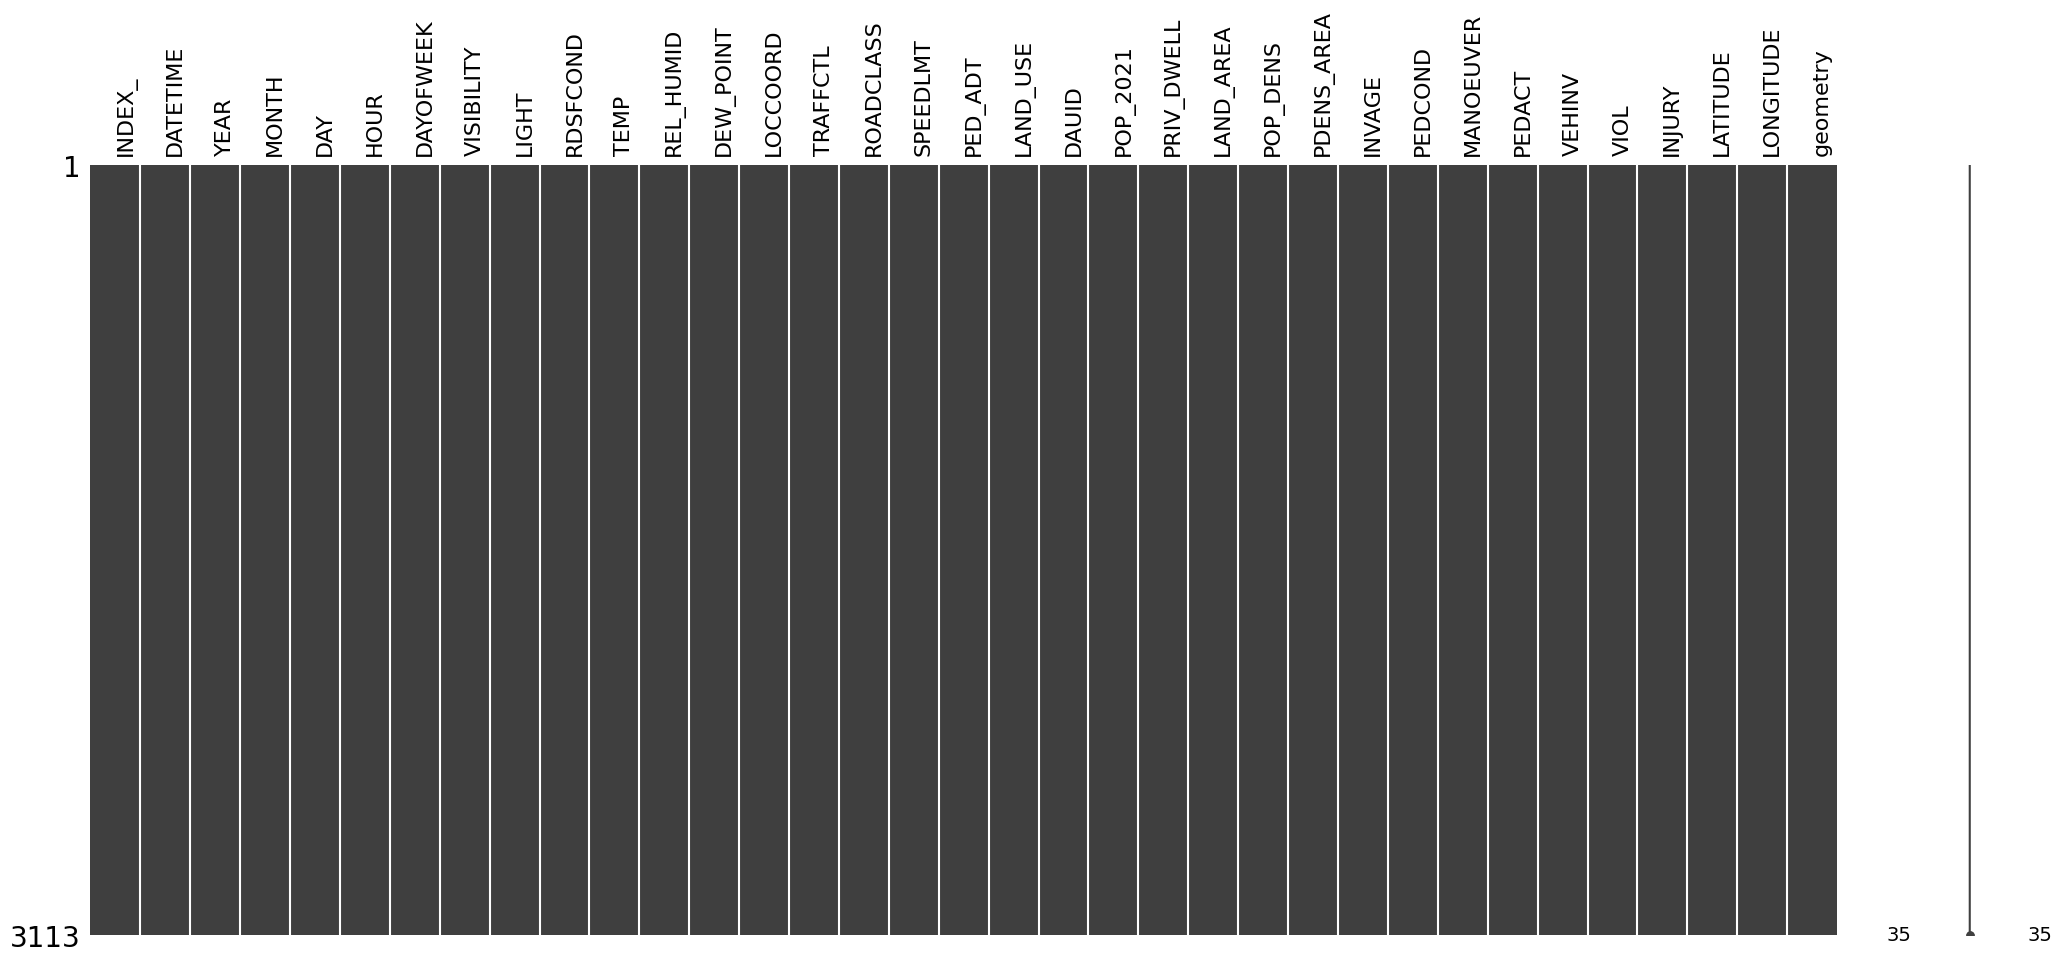

In [90]:
# Cleaned data no missing data
msno.matrix(DF4, label_rotation=90)
plt.tight_layout()
plt.savefig('no_missing_data.png', dpi=600)

# 6 Exporting Processed Data

In [91]:
GDF = gpd.GeoDataFrame(DF4)

In [92]:
GDF.to_file('processed_data_final.shp')
print('Export Complete!')

Export Complete!
